# Exercise 1: OOP & Pandas Practice

### Combine the baby names by state data set into a single file using shell commands.

In [ ]:
! mkdir -p ./dataset
! unzip babynamesbystate.zip -d ./dataset

In [ ]:
! cat ./dataset/babynamesbystate/*.TXT >> ./dataset/mergedData.TXT
#! tail -f ./dataset/mergedData.TXT & 

### 1. Create a class called BabyNames

for popularity, shall we consider those names which are present in 1 year and not present in 2nd year ?

In [42]:
import math
import matplotlib.pyplot as plt
import pandas as pd

class BabyNames(object):
    def __init__(self, dataset_path):
        column_names = ["StateCode","Sex","BirthYear","CharacterName","NumOccurences"]
        self.dataset = pd.read_csv(dataset_path, quotechar='"', sep=',', header=None, names=column_names)
        self.dataset = self.dataset.astype({"BirthYear": str, "NumOccurences": int})
    
    def get_state_year_df(self, state, year):
        if len(state) > 0 and len(year) > 0:
            df = self.dataset[(self.dataset.StateCode == state) & (self.dataset.BirthYear == year)]
        elif len(state) == 0 and len(year) > 0:
            df = self.dataset[self.dataset.BirthYear == year]
        elif len(state) > 0 and len(year) == 0:
            df = self.dataset[self.dataset.StateCode == state]
        else:
            df = self.dataset
        return df
    
    def count(self, state='', year=''):
        state_year_df = self.get_state_year_df(state, year)
        total_birth_count = state_year_df['NumOccurences'].sum()
        return total_birth_count

    def top10babynames(self, state='', year=''):
        topK = 10
        state_year_df = self.get_state_year_df(state, year)
        male_baby_list = (state_year_df[state_year_df.Sex == 'M']
                          .groupby('CharacterName')
                         .sum()
                         .reset_index()
                         .sort_values(by=['NumOccurences'], ascending=False)
                         .iloc[:topK].CharacterName.tolist())
        female_baby_list = (state_year_df[state_year_df.Sex == 'F']
                         .groupby('CharacterName')
                         .sum()
                         .reset_index()
                         .sort_values(by=['NumOccurences'], ascending=False)
                         .iloc[:topK].CharacterName.tolist())
        
        print(male_baby_list, female_baby_list)
        rank_list = list(range(1, topK+1))
        result_df = pd.DataFrame({
            "Rank" : rank_list,
            "Male" : male_baby_list,
            "Female" : female_baby_list
        })
        return result_df
            
    def change_of_popularity(self, fromYear, toYear, top=10):
        """
        # Do we consider the gender ?? 
        Definition of Popularity for a given Year yi
            Popularity(NamesA) = NumOccurences(NamesA)(yi)
        """
        dfA = self.dataset[self.dataset.BirthYear == fromYear].groupby('CharacterName')['NumOccurences'].sum().to_dict()
        dfB = self.dataset[self.dataset.BirthYear == toYear].groupby('CharacterName')['NumOccurences'].sum().to_dict()
        
        unique_names = self.dataset.CharacterName.unique().tolist()
        posPop = {}
        negPop = {}
        equalPop = {}
        for name in unique_names:
            freqA = dfA.get(name, 0)
            freqB = dfB.get(name, 0)
            
            if freqB > freqA:
                # Increase
                posPop[name] = freqB - freqA
            elif freqA > freqB:
                # Decrease
                negPop[name] = abs(freqB - freqA)
            else:
                # Same
                equalPop[name] = freqA
        #import pdb;pdb.set_trace();
        df_posPop = pd.DataFrame({"Name" : posPop.keys(), "Pop": posPop.values()})
        df_negPop = pd.DataFrame({"Name" : negPop.keys(), "Pop": negPop.values()})
        df_equalPop = pd.DataFrame({"Name" : equalPop.keys(), "Pop": equalPop.values()})
                
        df_posPop = df_posPop.sort_values(by=['Pop','Name'], ascending=[False, True]).iloc[:top]
        df_negPop = df_negPop.sort_values(by=['Pop', 'Name'], ascending=[False, True]).iloc[:top]
        df_equalPop = df_equalPop.sort_values(by=['Pop','Name'], ascending=[False,True]).iloc[:top]
                
        return {
            "increasingPopularity" : df_posPop.Name.tolist(),
            "decreasingPo?pularity" : df_negPop.Name.tolist(),
            "equalPopularity" : df_equalPop.Name.tolist()
        }
    
    def top5_names_per_year(self, year, sex=''):
        assert year is not None or len(year) > 0, f"year is a mandatory field"
        
        topk = 5
        if len(sex) == 0:
            filter_df = self.dataset[(self.dataset.BirthYear == year)]
        else:
            filter_df = self.dataset[(self.dataset.BirthYear == year) & (self.dataset.Sex == sex)]
         
        filter_df = filter_df.groupby('StateCode')
        row_list = []
        for state, state_df in filter_df:
            state_df = state_df.sort_values(by=['NumOccurences','CharacterName','Sex'], ascending=[False, True, True]).iloc[:topk]
            curr_row = []
            curr_row.append(state)
            for idx, row in enumerate(state_df.itertuples()):
                curr_row.append(row.CharacterName)
                curr_row.append(row.NumOccurences)
            
            row_list.append(curr_row)
        
        result_df = pd.DataFrame(row_list, columns=['State', 'Rank1', 'Rank1_Num',
                                          'Rank2', 'Rank2_Num', 'Rank3',
                                          'Rank3_Num', 'Rank4', 'Rank4_Num',
                                          'Rank5', 'Rank5_Num'])
        return result_df
    
    
    
    def name_popularity_plot(self, name, yearRange, state, sex):
        """
        Definition of Popularity
            For a given state and Year, 
                Popularity(NameA) = Occurences(NameA) / Summation[i](Occurences(Names[i]))
        """
        startYear = int(yearRange[0])
        endYear = int(yearRange[1])
        
        popularity_list = []
        for year in range(startYear, endYear+1):
            state_year_df = self.dataset[(self.dataset.BirthYear == str(year)) & (self.dataset.StateCode == state)]
            person_occ = state_year_df[(state_year_df.CharacterName==name) & (state_year_df.Sex==sex)]['NumOccurences']
            if person_occ.shape[0] == 0:
                person_occ = 0
            else:
                person_occ = int(person_occ.iloc[0])
            person_pop = person_occ 
            #/ state_year_df['NumOccurences'].sum() * 100
            popularity_list.append(person_pop)
            
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
        ax.plot(list(range(startYear, endYear+1)),popularity_list)
        ax.set_xlabel('Year')
        ax.set_ylabel('Popularity in %')
        ax.set_title(f"Popularity Trend Chart for {name}/{sex} from Year {startYear} to {endYear} in the state of {state}" )
        ax.grid()
        plt.show()
    
    def name_flip(self, n):
        """
        A flip is considered if abs(diff(Count(NameA,M), Count(NameA,F))) > 0
        The metric to calculate topk flips is abs(diff(Count(NameA,M), Count(NameA,F))) in descending order
        
        For each Name, plot the male and female count for each year
        """
        topk = n
        name_count_df = self.dataset.groupby(['CharacterName','Sex','Year']).size().unstack(fill_value=0)
        flipped_names = []
        for row in name_count_df.itertuples():
            if row.F > 0 and row.M > 0:
                flipped_names.append(row.Index)
        flip_metric = []
        for name in flipped_names:
            name_row = name_count_df[name_count_df.index == name]
            name_metric = abs(name_row.F.iloc[0] - name_row.M.iloc[0])
            flip_metric.append((name, name_metric))
        
        flip_metric = sorted(flip_metric, key=lambda x : x[1], reverse=True)[:topk]
        topk_flip_names = [ _[0] for _ in flip_metric]
        return topk_flip_names

In [43]:
babyName = BabyNames(dataset_path = './dataset/mergedData.TXT')

In [36]:
babyName.count('CA','2000')

471610

In [28]:
babyName.top10babynames()

['James', 'John', 'Robert', 'Michael', 'William', 'David', 'Richard', 'Joseph', 'Charles', 'Thomas'] ['Mary', 'Patricia', 'Elizabeth', 'Jennifer', 'Linda', 'Barbara', 'Margaret', 'Susan', 'Dorothy', 'Jessica']


,Rank,Male,Female
0,1,James,Mary
1,2,John,Patricia
2,3,Robert,Elizabeth
3,4,Michael,Jennifer
4,5,William,Linda
5,6,David,Barbara
6,7,Richard,Margaret
7,8,Joseph,Susan
8,9,Charles,Dorothy
9,10,Thomas,Jessica


In [37]:
babyName.change_of_popularity(fromYear='2014', toYear='2015', top=10)

{'increasingPopularity': ['Oliver',
  'Alexa',
  'Mia',
  'Hazel',
  'Grayson',
  'Matteo',
  'Charlotte',
  'Mateo',
  'Lincoln',
  'Scarlett'],
 'decreasingPo?pularity': ['Jayden',
  'Isabella',
  'Jase',
  'Sophia',
  'Joshua',
  'Annabelle',
  'Andrew',
  'Peyton',
  'Michael',
  'Alexis'],
 'equalPopularity': ['Danny',
  'Rosa',
  'Hadassah',
  'Lara',
  'Yousef',
  'Azaria',
  'Abdiel',
  'Reuben',
  'Kymani',
  'Abner']}

In [ ]:
8038 - 6681

In [ ]:
name_count_df  = babyName.dataset.groupby(['CharacterName','Sex', 'BirthYear']).size().unstack(fill_value=0)
name_count_df.head()

In [ ]:
flipped_names = []
for row in name_count_df.itertuples():
    if row.F > 0 and row.M > 0:
        flipped_names.append(row.Index)

In [ ]:
babyName.name_flip(20)

In [39]:
babyName.top5_names_per_year(year='2013', sex='M').head()

,State,Rank1,Rank1_Num,Rank2,Rank2_Num,Rank3,Rank3_Num,Rank4,Rank4_Num,Rank5,Rank5_Num
0,AK,Liam,64,William,49,Mason,47,Noah,46,Wyatt,46
1,AL,William,438,Mason,293,James,288,John,281,Elijah,247
2,AR,William,196,Mason,187,Noah,161,James,147,Elijah,138
3,AZ,Jacob,389,Noah,389,Liam,388,Alexander,370,Daniel,362
4,CA,Jacob,2890,Ethan,2667,Daniel,2603,Jayden,2581,Matthew,2565


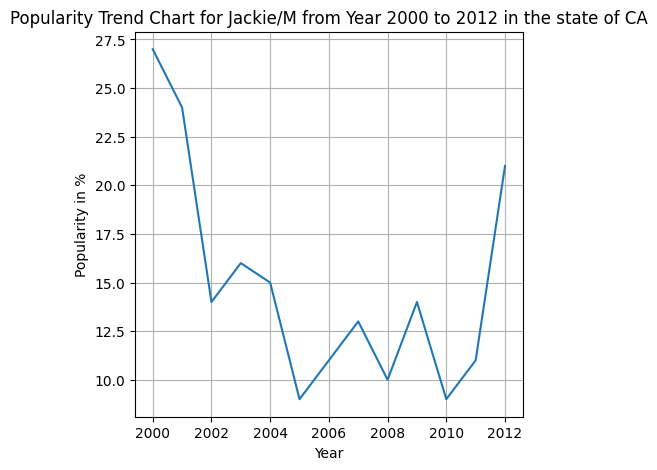

In [44]:
babyName.name_popularity_plot(name='Jackie', yearRange=('2000','2012'), state='CA',sex='M')

In [ ]:
df = babyName.dataset

In [ ]:
df.head()

In [ ]:
df.groupby(['CharacterName', 'Sex']).size()
#unstack(fill_value=0)

In [ ]:
for row in df.groupby(['CharacterName', 'Sex']).size().unstack(fill_value=0).itertuples():
    print(row.F, row.M)
    break